In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import os, sys, time, datetime, random
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Visited cells
visited_mark = 0.9
target_mark = 0.5
human_mark = 0.2


# Actions dictionary
actions_dict = {
    0: 'left',
    1: 'up',
    2: 'right',
    3: 'down',
    4: 'do nothing'
}

num_actions = len(actions_dict)

In [0]:
class Maze:
    def __init__(self, maze, target_list, human = (0, 0), hint = 4):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self._targets = target_list
        self.terminal_cell = self._maze[nrows-1, ncols-1]
        self.free_cells = self.get_free_cells()
        self.free_cells.discard(self.terminal_cell)
        self.blocked_cells = self.get_blocked_cells()
        self.reset(human, hint)
        
    def reset(self, human = (0,0),  hint= 4):
        self.hint = hint
        self.human = human
        self.maze = np.copy(self._maze)
        self.targets = set(self._targets)
        #print(self.targets)
        nrows, ncols = self.maze.shape
        row, col = human
        self.maze[row, col] = human_mark
        self.state = ((row, col), 'start')
        self.base = np.sqrt(self.maze.size)
        self.visited = self.visited = dict(((r,c),0) for r in range(nrows) 
                                           for c in range(ncols) if self._maze[r,c] == 1.0)
        self.total_reward = 0
        self.min_reward =  -0.4 * self.maze.size
        self.reward = {
            'blocked'      :  self.min_reward,
            'targets'      :  1.0/len(self._targets),
            'invalid'      : -4.0/self.base,
            'valid'        : -1/self.maze.size, #(1 + 0.1*self.visited[agent] ** 2)
            'hint_penalty' : -2/self.maze.size
        }
    
    def get_visited_cells(self):
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        visited = dict(((r,c),0) 
             for r in range(self.maze.nrows) 
             for c in range(self.maze.ncols) if self._maze[r,c] == 1.0)
        return visited
    
    def valid_actions(self, cell = None):
        if cell is None:
            row, col = self.human
        else:
            row, col = cell
        nrows, ncols = self.maze.shape
        actions = [0, 1, 2, 3]
        
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
            
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)
        
        if row > 0 and self.maze[row-1, col] == 0:
            actions.remove(1)
        if row < nrows-1 and self.maze[row+1, col] == 0:
            actions.remove(3)
            
        if col>0 and self.maze[row, col-1] == 0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row, col+1] ==0:
            actions.remove(2) 
            
        return actions
        
    def get_action(self, hint = 4):
        #Get next action based on hint
        if hint == 4:
            action = random.choice(self.valid_actions())
        else:
            action = hint
            
        return action
    
    def act(self, hint, action):
        #Take action, update state and reward
        #print(hint, action)
        self.update_state(action)
        reward = self.get_reward(hint)
        self.total_reward += reward
        status = self.game_status()
        env_state = self.observe()
        return env_state, reward, status
    
    def get_reward(self, hint = 4):
        #
        human, mode = self.state
        penalty = 0
        if hint != 4:
            penalty =  self.reward['hint_penalty']
            
        if np.all(human == self.terminal_cell) and len(self.targets) == 0:
            return penalty + 1.0
        elif human in self.targets:
            return penalty + self.reward['targets']
        
        if mode =='blocked':
            return penalty + self.reward['blocked']
        elif mode == 'invalid':
            return penalty + self.reward['invalid']
        elif mode == 'valid':
            return (penalty + self.reward['valid']) * self.visited[self.human] ** 3
        
        

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        (nrow, ncol), nmode = human, mode = self.state
        #print ('HUman :' + str(human))

        if self.maze[human] > 0.0:
            self.visited[human] += 1  # mark visited cell
        if human in self.targets:
            self.targets.remove(human)
        
        valid_actions = self.valid_actions(human)
        #print('Valid actions: ' +  str(valid_actions))
            
        #if not valid_actions: #doubtful
        #    nmode = 'blocked'
        if action in valid_actions:
            nmode = 'valid'
            if action == 0:
                ncol -=1
            elif action == 1:
                nrow -=1
            elif action == 2:
                ncol += 1
            elif action == 3:
                nrow += 1
        else:
            nmode = 'blocked'
        
        human = (nrow, ncol)
        self.human = human
        self.state = (human, nmode)
        
        #print(self.state)
        
    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        human, mode = self.state
        if np.all(human == self.terminal_cell):
            if len(self.targets) == 0:
                return 'win'
            else:
                return 'lose'
        return 'ongoing'
    
    def observe(self):
        canvas = self.draw_env()
        env_state = canvas.reshape((1, -1))
        return env_state
    
    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the targets
        for r,c in self.targets:
            canvas[r,c] = target_mark
        # draw the human
        human, mode = self.state
        #print(mode)
        #print(human)
        
        canvas[human] = human_mark
        #print(canvas)
        return canvas
        
    def get_blocked_cells(self):
        nrows, ncols = self._maze.shape
        blocked_cells =set ((r,c) for r in range(nrows) for c in range(ncols) if maze1[r,c] == 0.0)
        return blocked_cells
    
    def get_free_cells(self):
        #    self.maze = np.copy(self._maze)
        nrows, ncols = self._maze.shape
        free_cells = set((r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0)
        return free_cells
    

In [0]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.97):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [env_state, action, reward, next_env_state, game_over]
        # memory[i] = episode
        # env_state == flattened 1d maze cells info, including agent cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, env_state):
        return self.model.predict(env_state)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # env_state 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        labels = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            env_state, action, reward, next_env_state, game_over = self.memory[j]
            inputs[i] = env_state
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep (quote by Eder Santana)
            labels[i] = self.predict(env_state)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(next_env_state))
            if game_over:
                labels[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                labels[i, action] = reward + self.discount * Q_sa
        return inputs, labels

In [0]:
class Qtraining():
    def __init__(self, model, env, **opt):
        self.model = model #NN model
        self.env = env     #Environment
        self.n_epoch = opt.get('n_epoch', 1000)
        self.max_memory = opt.get('max_memory', 4* self.env.maze.size)
        self.data_size = opt.get('data_size', 0.75* self.env.maze.size)
        self.start_cell = opt.get('start_cell', (0, 0))
        self.init_hint = 4
        self.weights_file = opt.get('weights_file', "")
        self.name = opt.get('name', 'model')
        self.win_count = 0
        self.curr_epoch = 0
        self.hint_list = []
        self.item_collected = 0
        
        if self.weights_file:
            print('Loading weights from file: %s' % (self.weights_file,))
            self.model.load_weights(self.weights_file)
            
        ##if self.human_cells = 'all':
        ##    self.human_cells = self.env.free_cells
            
        #Initialize experience replay object
        self.experience = Experience(self.model, max_memory= self.max_memory)
        
    def train(self):
        start_time = datetime.datetime.now()
        self.seconds = 0
        self.win_count = 0
        self.curr_epoch = 0
        self.hint_list = []
        for epoch in range(self.n_epoch):
            self.epoch = epoch
            self.curr_epoch += 1
            self.loss = 0.0
            human = self.start_cell
            #print(all_targets)
            self.env.reset(self.start_cell, self.init_hint)
            game_over = False
            self.env_state = self.env.observe()
            self.n_episodes = 0
            self.hint_list = []
            while not game_over:
                game_over = self.play()

            dt = datetime.datetime.now() - start_time
            self.seconds = dt.total_seconds()
            t = format_time(self.seconds)
            fmt = "Epoch: {:3d}/{:d} | Loss: {:.4f} | Episodes: {:4d} | Wins: {:2d} | Targets: {:d} | e: {:.3f} | time: {}"
            print(fmt.format(epoch, self.n_epoch-1, self.loss, self.n_episodes, self.win_count, len(self.env.targets), self.epsilon(), t))
            print(str(env.total_reward) + str(env.targets) + str(env.state))
            print('Hints :' +str(self.hint_list))

            self.item_collected += (len(self.env._targets) - len(self.env.targets)) / 3

            if self.win_count > 2:
                if self.completion_check():
                    print("Completed training at epoch: %d" %(epoch, ))
                    break     
    def play(self):
        hint = self.get_hint()
        action = self.env.get_action(hint)
        prev_env_state = self.env_state
        self.env_state, reward, game_status = self.env.act(hint, action)
        #print(game_status)
        #print(env.total_reward)
        if game_status == 'win':
            self.win_count += 1
            game_over = True
        elif game_status == 'lose':
            game_over = True
        else:
            game_over = False

        #episode = [prev_env_sate, action, hint, reward, self.env_state, game_over]
        episode = [prev_env_state, hint, reward, self.env_state, game_over]

        self.experience.remember(episode)
        self.n_episodes += 1

        # Train model
        inputs, targets = self.experience.get_data(data_size=self.data_size)
        epochs = int(self.env.base)
        h = self.model.fit(
            inputs,
            targets,
            epochs = epochs,
            batch_size=16,
            verbose=0,
        )
        self.loss = self.model.evaluate(inputs, targets, verbose=0)
        return game_over
        
    def run_game(self, human, hint):
        self.env.reset(human, hint)
        env_state = self.env.observe()
        while True:
            #get next hint
            q = self.model.predict(env_state)
            hint = np.argmax(q[0])
            action = self.env.get_action(hint)
            prev_env_state = env_state
            #Apply hint
            env_state, reward, game_status = self.env.act(hint, action)
            if game_status == 'win':
                return True
            elif game_status == 'lose':
                return False

    def get_hint(self):
        #Get next hint
        valid_hints = self.env.valid_actions() + [4]
        if np.random.rand()< self.epsilon():
            hint = random.choice(valid_hints)
        else:
            q = self.experience.predict(self.env_state)
            hint = np.argmax(q)
        self.hint_list.append(hint)
        return hint
        
    def epsilon(self):
        #n = self.win_count
        n = self.item_collected
        high = 0.25
        low = 0.05
        e = low + (high - low) /  (1 + 0.01 * n**0.5 )
        return e
        
    def completion_check(self):
        if not self.run_game(self.start_cell):
            return False
        return True
    
    def save(self, name=""):
        # Save trained model weights and architecture, this will be used by the visualization code
        if not name:
            name = self.name
        h5file = 'model_%s.h5' % (name,)
        json_file = 'model_%s.json' % (name,)
        self.model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
        t = format_time(self.seconds)
        print('files: %s, %s' % (h5file, json_file))
        print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (self.epoch, self.max_memory, self.data_size, t))

In [0]:
def build_model(env, **opt):
    loss = opt.get('loss', 'mse')
    a = opt.get('alpha', 0.24)
    model = Sequential()
    esize = env.maze.size
    model.add(Dense(esize, input_shape = (esize,)))
    model.add(LeakyReLU(alpha = a))
    model.add(Dense(esize))
    model.add(LeakyReLU(alpha = a))
    model.add(Dense(num_actions))
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

In [0]:
def show_env(env, fname=None):
    plt.grid('on')
    n = env.maze.shape[0]
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, n, 1))
    ax.set_yticks(np.arange(0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(env.maze)
    for cell in env.visited:
        if env.visited[cell]:
            canvas[cell] = visited_mark
    for cell in env.targets:
        canvas[cell] = target_mark
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    if fname:
        plt.savefig(fname)
    return img

def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [0]:
maze1 = np.asarray([
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

all_targets = [(0, 4), (2,3), (4,3)]

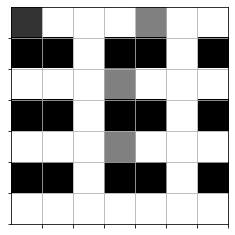

In [10]:
env = Maze(maze1, all_targets)
show_env(env)

In [0]:
model = build_model(env)

qt = Qtraining(
    model,
    env,
    n_epoch = 10000,
    max_memory = 1000,
    data_size = 256,
    name = 'model_1'
)

qt.train()

Epoch:   0/9999 | Loss: 11.2878 | Episodes:   12 | Wins:  0 | Targets: 2 | e: 0.250 | time: 2.8 seconds
-39.00952380952381{(2, 3), (4, 3)}((2, 6), 'blocked')
Hints :[2, 2, 2, 2, 2, 3, 2, 3, 3, 4, 2, 3]
Epoch:   1/9999 | Loss: 5.6941 | Episodes:   14 | Wins:  0 | Targets: 3 | e: 0.249 | time: 4.0 seconds
-32.57959183673469{(2, 3), (4, 3), (0, 4)}((0, 1), 'blocked')
Hints :[4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 1, 0, 1]
Epoch:   2/9999 | Loss: 0.5636 | Episodes:   33 | Wins:  0 | Targets: 2 | e: 0.249 | time: 9.4 seconds
-27.238095238095244{(2, 3), (4, 3)}((0, 5), 'valid')
Hints :[4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 2, 3, 4, 4, 1, 4, 2, 2, 4, 4, 4, 4, 4, 1, 4, 4, 3, 1, 3, 4, 3, 1]
Epoch:   3/9999 | Loss: 0.4301 | Episodes:   21 | Wins:  0 | Targets: 2 | e: 0.248 | time: 15.2 seconds
-22.523809523809522{(4, 3), (0, 4)}((2, 5), 'valid')
Hints :[4, 2, 4, 2, 4, 4, 4, 4, 2, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4]
Epoch:   4/9999 | Loss: 0.4068 | Episodes:   23 | Wins:  0 | Targets: 2 | e: 0.248 | time: 2